# This file is an example on how to train your own model; this is meant to be customized to fit your MediaPipe needs!

In [ ]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
!unzip rps_data_sample.zip
dataset_path = "rps_data_sample"

--2023-05-23 20:01:48--  https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12332447 (12M) [application/zip]
Saving to: ‘rps_data_sample.zip.2’

rps_data_sample.zip 100%[===================>]  11.76M  --.-KB/s    in 0.07s   

2023-05-23 20:01:48 (173 MB/s) - ‘rps_data_sample.zip.2’ saved [12332447/12332447]

Archive:  rps_data_sample.zip
replace rps_data_sample/paper/77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
print(dataset_path)
# labels = []
# for i in os.listdir(dataset_path):
#   if os.path.isdir(os.path.join(dataset_path, i)):
#     labels.append(i)
# print(labels)

# NUM_EXAMPLES = 5

# for label in labels:
#   label_dir = os.path.join(dataset_path, label)
#   example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
#   fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
#   for i in range(NUM_EXAMPLES):
#     axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
#     axs[i].get_xaxis().set_visible(False)
#     axs[i].get_yaxis().set_visible(False)
#   fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

# plt.show()

data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

model.export_model()
!ls exported_model

#files.download('exported_model/gesture_recognizer.task')

rps_data_sample
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite


KeyboardInterrupt: ignored

In [ ]:
!ls /tmp/model_maker/gesture_recognizer/gesture_embedder

keras_metadata.pb  saved_model.pb  variables


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

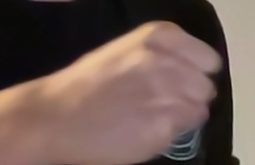

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/rps_data_sample/rock/133.jpg")
cv2_imshow(img)

In [ ]:
BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = python.BaseOptions(model_asset_path='/content/exported_model/gesture_recognizer.task')
options = GestureRecognizerOptions(
    base_options=base_options,
    running_mode=VisionRunningMode.IMAGE)
recognizer = vision.GestureRecognizer.create_from_options(options)

In [ ]:
image = mp.Image.create_from_file("/content/rps_data_sample/rock/133.jpg")
gesture_recognition_result = recognizer.recognize(image)

results = gesture_recognition_result.hand_landmarks

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
    gesture_landmark_list = detection_result.hand_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(gesture_landmark_list)):
        hand_landmarks = gesture_landmark_list[idx]

        # Convert hand landmarks to the required format.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        #print(hand_landmarks_proto)
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        #print(hand_landmarks_proto)

        # Draw the hand landmarks on the image.
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=hand_landmarks_proto,
            connections=mp.solutions.hands_connections.HAND_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_styles.
            get_default_hand_landmarks_style(),
            connection_drawing_spec=mp.solutions.drawing_styles.
            get_default_hand_connections_style())

    return annotated_image

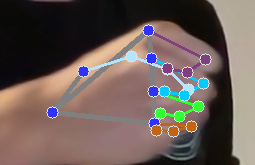

In [ ]:
annotated_image = draw_landmarks_on_image(image.numpy_view(), gesture_recognition_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
top_gesture = gesture_recognition_result.gestures[0][0]
hand_landmarks = gesture_recognition_result.hand_landmarks

print(top_gesture)

Category(index=-1, score=0.8168337941169739, display_name='', category_name='rock')
